# Multi-Scale Mask R-CNN People Detection

Pipeline for robust human detection using Mask R-CNN (ResNet-50 FPN). 
Includes image enhancement, multi-scale pyramid inference, non-maximum suppression (NMS), 
bounding-box merging for de-duplication, and heatmap visualization. 
Supports dataset filtering, remote image fetching, and batch preview with counts.

/tmp/ipykernel_1606344/125505158.py:120: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(BytesIO(response.content))


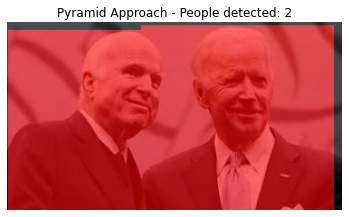

Title Text: Kasie Hunt: Congress will not be the same without Sen. McCain
Filter Word: 
Pyramid Approach - Number of People Detected: 2
----------------------------------


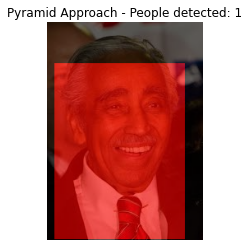

Title Text: Rangel's Victory Margin Shrinks in New Vote Tally - The New York Times
Filter Word: 
Pyramid Approach - Number of People Detected: 1
----------------------------------


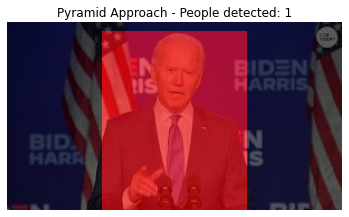

Title Text: Election 2020: Montana Native American's vote for Biden over Trump
Filter Word: 
Pyramid Approach - Number of People Detected: 1
----------------------------------


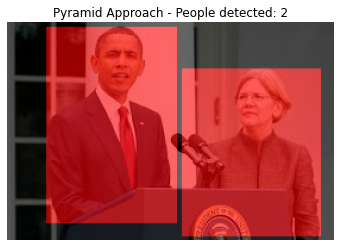

Title Text: Obama Passes Over Warren, Names Deputy to Run Consumer Agency | TIME.com
Filter Word: 
Pyramid Approach - Number of People Detected: 2
----------------------------------


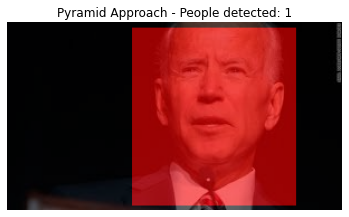

Title Text: 190327083130-02-joe-biden-03162019-story-top.jpg
Filter Word: 
Pyramid Approach - Number of People Detected: 1
----------------------------------


In [14]:
import cv2
import numpy as np
import pandas as pd
import requests
from io import BytesIO
import imageio
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.ops import nms

def load_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.to(device)
    model.eval()
    return model, device

def enhance_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_equalized = cv2.equalizeHist(gray)
    image[:, :, 0] = gray_equalized
    image[:, :, 1] = gray_equalized
    return image

def create_image_pyramid(image, scales):
    return [cv2.resize(image, None, fx=scale, fy=scale) for scale in scales]

def apply_nms(boxes, scores, iou_threshold=0.3, score_threshold=0.8, min_area=500):
    if len(boxes) == 0:
        return np.array([]), np.array([])
    boxes = torch.tensor(boxes)
    scores = torch.tensor(scores)
    keep = nms(boxes, scores, iou_threshold=iou_threshold)
    boxes, scores = boxes[keep].numpy(), scores[keep].numpy()
    filtered_boxes, filtered_scores = [], []
    for b, s in zip(boxes, scores):
        area = (b[2] - b[0]) * (b[3] - b[1])
        if s >= score_threshold and area >= min_area:
            filtered_boxes.append(b)
            filtered_scores.append(s)
    return np.array(filtered_boxes), np.array(filtered_scores)

def merge_boxes(boxes, iou_threshold=0.5):
    if len(boxes) == 0:
        return np.array([])
    merged = []
    boxes = list(boxes)
    while len(boxes) > 0:
        ref = boxes[0]
        overlaps, rest = [ref], []
        for b in boxes[1:]:
            inter_x1 = max(ref[0], b[0]); inter_y1 = max(ref[1], b[1])
            inter_x2 = min(ref[2], b[2]); inter_y2 = min(ref[3], b[3])
            inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
            union_area = (ref[2] - ref[0]) * (ref[3] - ref[1]) + (b[2] - b[0]) * (b[3] - b[1]) - inter_area
            iou = inter_area / union_area if union_area > 0 else 0
            if iou > iou_threshold:
                overlaps.append(b)
            else:
                rest.append(b)
        merged_box = np.median(np.array(overlaps), axis=0)
        merged.append(merged_box)
        boxes = rest
    return np.array(merged)

def pyramid_mask_rcnn_detect_people(image, model, device, scales=[1.1, 0.75, 0.25]):
    enhanced_image = enhance_image(image.copy())
    pyramid = create_image_pyramid(enhanced_image, scales)
    pyramid_tensors = [torch.tensor(img).permute(2, 0, 1).float() / 255.0 for img in pyramid]
    pyramid_tensors = [img.to(device) for img in pyramid_tensors]
    all_boxes, all_scores = [], []
    with torch.no_grad():
        predictions = model(pyramid_tensors)
    for i, pred in enumerate(predictions):
        person_indices = [j for j, label in enumerate(pred['labels'].cpu().numpy()) if label == 1]
        boxes = pred['boxes'].cpu().numpy()[person_indices] / scales[i]
        scores = pred['scores'].cpu().numpy()[person_indices]
        all_boxes.extend(boxes)
        all_scores.extend(scores)
    nms_boxes, _ = apply_nms(np.array(all_boxes), np.array(all_scores))
    merged_boxes = merge_boxes(nms_boxes, iou_threshold=0.5)
    return merged_boxes

def apply_heatmap(image, boxes, alpha=0.6):
    heatmap = np.zeros_like(image, dtype=np.uint8)
    for box in boxes:
        box = list(map(int, box))
        cv2.rectangle(heatmap, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), -1)
    cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0, image)

def preview_photos_with_filter(dataset, num_photos, filter_word, mask_rcnn_model, device):
    df = pd.read_csv(dataset)
    df.dropna(subset=['image'], inplace=True)
    filtered_df = df[df['title'].str.contains(filter_word, case=False, na=False)]
    sample_df = filtered_df.sample(min(num_photos, len(filtered_df)))
    for _, row in sample_df.iterrows():
        image_url = row['image']
        title = row['title']
        try:
            response = requests.get(image_url)
            response.raise_for_status()
        except requests.RequestException:
            print(f"Failed to download image for title: {title}")
            continue
        img = imageio.imread(BytesIO(response.content))
        img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        final_boxes = pyramid_mask_rcnn_detect_people(img_cv2, mask_rcnn_model, device)

# Face Verification for Political Figures  

## Code 1: Build Face Embedding Representatives  

This script constructs representative embeddings for each political figure:  
- Loads images from URLs or base64.  
- Extracts face embeddings using **InsightFace**.  
- Averages embeddings per person to form a representative vector.  
- Saves all representatives into a `pattern_representatives.pkl` file.  


In [ ]:
import requests
import numpy as np
import cv2
import pandas as pd
from insightface.app import FaceAnalysis
import base64
import pickle

def load_insightface_model():
    app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=-1, det_size=(640, 640))
    return app

def process_image(data_uri_or_url):
    if data_uri_or_url.startswith('http'):
        response = requests.get(data_uri_or_url)
        if response.status_code == 200:
            img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            return img
        else:
            return None
    elif data_uri_or_url.startswith('data:image'):
        base64_str_index = data_uri_or_url.find('base64,') + len('base64,')
        img_base64 = data_uri_or_url[base64_str_index:]
        img_bytes = base64.b64decode(img_base64)
        img_array = np.frombuffer(img_bytes, dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        return img
    else:
        return None

def get_embedding(app, img):
    faces = app.get(img)
    if faces:
        return faces[0].normed_embedding
    else:
        return None

def get_representative_embedding(app, image_urls):
    embeddings = []
    for url in image_urls:
        img = process_image(url)
        if img is not None:
            embedding = get_embedding(app, img)
            if embedding is not None:
                embeddings.append(embedding)
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return None

def compare_to_template(representative_embedding, embedding):
    similarity = np.dot(representative_embedding, embedding) / (
        np.linalg.norm(representative_embedding) * np.linalg.norm(embedding)
    )
    return similarity

df = pd.read_csv('Poilitical Person Sample.csv')
app = load_insightface_model()

pattern_representatives = {}
for individual, group in df.groupby('Political Person'):
    image_urls = group['image'].tolist()
    rep_embedding = get_representative_embedding(app, image_urls)
    if rep_embedding is not None:
        pattern_representatives[individual] = rep_embedding

with open('pattern_representatives.pkl', 'wb') as file:
    pickle.dump(pattern_representatives, file)

## Code 2: Face Verification Against Representatives  
This script matches new images against stored representatives:  
- Loads embeddings from `pattern_representatives.pkl`.  
- Extracts embeddings for dataset images.  
- Finds top-3 most similar political figures using cosine similarity.  
- Parallelized with `ThreadPoolExecutor` for efficiency.  
- Outputs results into `cleaned_complete_data_Face_Verification.csv`. 

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import pickle
import concurrent.futures
from insightface.app import FaceAnalysis
from PIL import Image

def load_insightface_model():
    app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=-1, det_size=(640, 640))
    return app

def get_embedding(app, img):
    faces = app.get(img)
    if faces:
        return faces[0].normed_embedding
    else:
        return None

def compare_to_template(representative_embedding, embedding):
    if representative_embedding is not None and embedding is not None:
        similarity = np.dot(representative_embedding, embedding) / (
            np.linalg.norm(representative_embedding) * np.linalg.norm(embedding)
        )
        return similarity
    else:
        return -1

def find_top_similar_faces(new_embedding, pattern_representatives, k=3):
    similarities = []
    for person, rep_embedding in pattern_representatives.items():
        similarity = compare_to_template(rep_embedding, new_embedding)
        similarities.append((similarity, person))
    similarities.sort(reverse=True, key=lambda x: x[0])
    return similarities[:k]

def process_row(index, row, app, pattern_representatives, image_directory):
    image_id = row['ID']
    image_path = os.path.join(image_directory, f"{image_id}.jpg")
    try:
        img = Image.open(image_path).convert('RGB')
        img = np.array(img)
    except Exception:
        return None
    embedding = get_embedding(app, img)
    if embedding is not None:
        top_similar_people = find_top_similar_faces(embedding, pattern_representatives)
        result = {'index': index}
        for i, (similarity, person) in enumerate(top_similar_people):
            result[f'Top{i+1}_Person'] = person
            result[f'Top{i+1}_Score'] = similarity
        return result
    return None

def load_pattern_representatives(filename):
    with open(filename, 'rb') as file:
        pattern_representatives = pickle.load(file)
    return pattern_representatives

def process_dataset():
    pattern_representatives = load_pattern_representatives('pattern_representatives.pkl')
    df = pd.read_csv('cleaned_complete_data.csv')
    df['Top1_Person'] = ''
    df['Top1_Score'] = np.nan
    df['Top2_Person'] = ''
    df['Top2_Score'] = np.nan
    df['Top3_Person'] = ''
    df['Top3_Score'] = np.nan
    image_directory = 'images_Polarization'
    app = load_insightface_model()
    results = []
    processed_count = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = [
            executor.submit(process_row, index, row, app, pattern_representatives, image_directory)
            for index, row in df.iterrows()
        ]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            processed_count += 1
            if processed_count % 5000 == 0:
                print(f"{processed_count} records processed.")
            if result:
                results.append(result)
    for result in results:
        index = result['index']
        for key, value in result.items():
            if key != 'index':
                df.loc[index, key] = value
    df.to_csv('cleaned_complete_data_Face_Verification.csv', index=False)

if __name__ == "__main__":
    process_dataset()


# Political Annotation  

Adds publication names and political sides for outlets, politicians, and detected faces.  
Saves full (`_Info.csv`) and filtered (`_Info_Raady.csv`, Top1_Score > 0.5) datasets.  


In [ ]:
df = pd.read_csv('cleaned_complete_data_Face_Verification.csv')
unique_political_persons = df['Political Person'].unique()
unique_news_centers = df['News Center'].unique()
unique_dates = df['Date'].unique()

outlet_to_publication_map = {
    'www.bbc.com': 'BBC',
    'www.nytimes.com': 'NY Times',
    'www.huffpost.com': 'Huffington Post',
    'www.washingtonpost.com': 'Washington Post',
    'www.cnn.com': 'CNN',
    'www.cbsnews.com': 'CBS News',
    'www.latimes.com': 'LA Times',
    'news.yahoo.com': 'Yahoo News',
    'abcnews.go.com': 'ABC News',
    'www.wsj.com': 'WSJ',
    'www.foxnews.com': 'Fox News',
    'www.newsmax.com': 'Newsmax',
    'www.dailymail.co.uk': 'Daily Mail',
    'www.usatoday.com': 'USA Today',
    'www.nbcnews.com': 'NBC News',
    'www.usnews.com': 'US News',
    'time.com': 'TIME Magazine',
    'www.reuters.com': 'Reuters',
    'www.cnbc.com': 'CNBC',
    'www.csmonitor.com': 'CSMonitor'
}

political_side_map = {
    'Joe Biden': 'Democratic',
    'Kamala Harris': 'Democratic',
    'Nancy Pelosi': 'Democratic',
    'Barack Obama': 'Democratic',
    'Hillary Clinton': 'Democratic',
    'Chuck Schumer': 'Democratic',
    'Elizabeth Warren': 'Democratic',
    'Bernie Sanders': 'Democratic',
    'Joe Manchin': 'Democratic',
    'Cory Booker': 'Democratic',
    'Gavin Newsom': 'Democratic',
    'Amy Klobuchar': 'Democratic',
    'Bill de Blasio': 'Democratic',
    'Janet Yellen': 'Democratic',
    'Steny Hoyer': 'Democratic',
    'James Clyburn': 'Democratic',
    'Donald Trump': 'Republican',
    'Mitch Mcconnell': 'Republican',
    'Mike Pence': 'Republican',
    'Kevin McCarthy': 'Republican',
    'Liz Cheney': 'Republican',
    'Hal Rogers': 'Republican',
    'Mitt Romney': 'Republican',
    'John Roberts': 'Republican', 
    'Ted Cruz': 'Republican',
    'Rand Paul': 'Republican',
    'Marco Rubio': 'Republican',
    'Susan Collins': 'Republican',
    'Randy Biggs': 'Republican',
    'Greg Abbott': 'Republican'
}

outlet_side_map = {
    'www.bbc.com': 'Democratic',
    'www.nytimes.com': 'Democratic',
    'www.huffpost.com': 'Democratic',
    'www.washingtonpost.com': 'Democratic',
    'www.cnn.com': 'Democratic',
    'www.cbsnews.com': 'Democratic',
    'www.latimes.com': 'Democratic',
    'news.yahoo.com': 'Democratic',
    'abcnews.go.com': 'Democratic',
    'www.wsj.com': 'Republican',
    'www.foxnews.com': 'Republican',
    'www.newsmax.com': 'Republican',
    'www.dailymail.co.uk': 'Republican',
    'www.usatoday.com': 'Republican',
    'www.nbcnews.com': 'Republican',
    'www.usnews.com': 'Neutral',
    'time.com': 'Neutral',
    'www.reuters.com': 'Neutral',
    'www.cnbc.com': 'Neutral',
    'www.csmonitor.com': 'Neutral'
}

df['News Center Side'] = df['News Center'].map(outlet_side_map)
df['News Person Side'] = df['Political Person'].map(political_side_map)
df['Real Person Side'] = df['Top1_Person'].map(political_side_map)
df['Publication'] = df['News Center'].map(outlet_to_publication_map)

df.to_csv('cleaned_complete_data_Face_Verification_Info.csv', index=False)

df = df[df['Top1_Score'] > 0.50]
df.to_csv('cleaned_complete_data_Face_Verification_Info_Raady.csv', index=False)

# Heatmap Visualization  

Builds a pivot table of politician–news outlet frequencies (excluding Randy Biggs).  
Adds totals, scales by 95th percentile, and plots a heatmap for distribution patterns.  


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` par

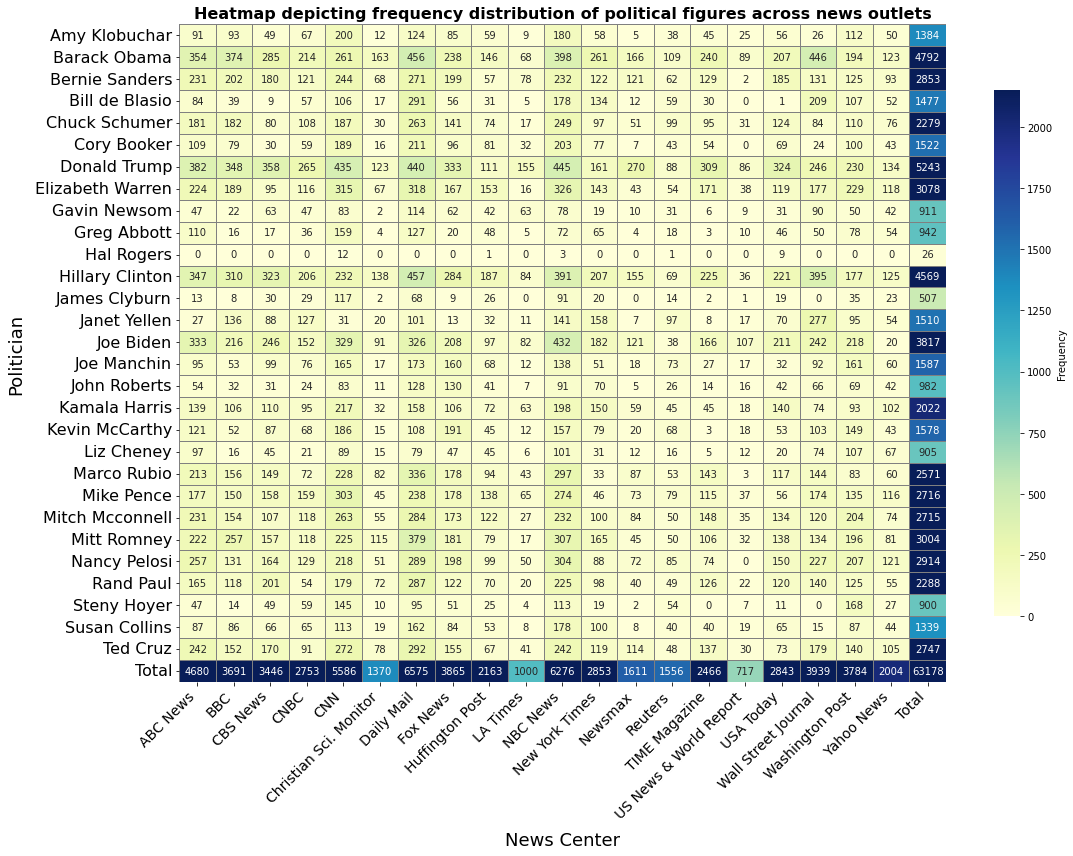

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
Data = pd.read_csv('cleaned_complete_data_Face_Verification_Info_Raady.csv')

# Exclude "Randy Biggs" from the dataset
Data = Data[Data['Political Person'] != "Randy Biggs"]

# Generate a pivot table to count occurrences of each Politician-News Center combination
pivot_table = Data.pivot_table(index='Political Person', columns='Publication', aggfunc='size', fill_value=0)

# Add a "Total" column and row
pivot_table["Total"] = pivot_table.sum(axis=1)
column_totals = pivot_table.sum(axis=0)
pivot_table.loc["Total"] = column_totals

# Determine the upper color limit by finding the 95th percentile value
upper_limit = pivot_table.quantile(0.50).max()

# Create a high-quality heatmap
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    vmax=upper_limit,
    cbar_kws={"shrink": 0.8, "label": "Frequency"},
)

# Improve aesthetics
plt.title("Heatmap depicting frequency distribution of political figures across news outlets", fontsize=16, weight="bold")
plt.xlabel("News Center", fontsize=18, labelpad=10)
plt.ylabel("Politician", fontsize=18, labelpad=10)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=16)

# Adjust layout for a clean display
plt.tight_layout()
plt.show()
